# Classificação e BB para o MultMNIST
* Dowloand dos pacotes e bibliotecas
* Criação do dataset e dataloader para os dados de treinamento
* Target cusumizado utilizando uma gausiana
* Criação de uma rede totalmente convolucional para comportar qualquer tamanho de entrada
* Treinamento com imagens e targets 28x28
* Comparação entre funções de custo MSE e CrossEntropy
* Predição de imagens de qualquer tamanho com multiplos digitos


## 1 - Dowloands e configurações

### 1.1 - Dowloands

In [1]:
!wget -nc -q https://raw.githubusercontent.com/robertoalotufo/files/master/lib/pytorch_trainer_v2.py -Plib/

### 1.2 - Importando os módulos

In [2]:
GOOGLE_COLAB = False

if GOOGLE_COLAB:
    from os import path
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag

    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

    !pip3 install http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

    # PIL workaround 
    from PIL import Image
    def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
    Image.register_extension = register_extension
    def register_extensions(id, extensions): 
        for extension in extensions: register_extension(id, extension)
    Image.register_extensions = register_extensions

import time
import os
import copy
import pickle
from math import sqrt, pow
import traceback
from random import random
from collections import OrderedDict
import multiprocessing as mp
from PIL import Image
import glob
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.utils import make_grid
from torchvision import transforms

from lib import pytorch_trainer_v2 as ptt
        
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    device = torch.device("cpu")
    torch.set_default_tensor_type('torch.FloatTensor')
   
  
from sklearn.model_selection import train_test_split

print("Tudo pronto!")

Tudo pronto!


In [3]:
!free -m    
!nvidia-smi

              total        used        free      shared  buff/cache   available
Mem:         245854        1073      243050           8        1729      243417
Swap:             0           0           0
Mon Nov 19 20:54:38 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.44                 Driver Version: 396.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:1B.0 Off |                    0 |
| N/A   49C    P0    43W / 300W |     11MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:0

### 1.3 - Funções uteis

In [4]:
class ImageUtil():
  
    @staticmethod
    def open_image(fn):
        """ Opens an image using OpenCV given the file path.

        Arguments:
            fn: the file path of the image

        Returns:
            The image in RGB format as numpy array of floats normalized to range between 0.0 - 1.0
        """
        flags = cv2.IMREAD_UNCHANGED+cv2.IMREAD_ANYDEPTH+cv2.IMREAD_ANYCOLOR
        if not os.path.exists(fn) and not str(fn).startswith("http"):
            raise OSError('No such file or directory: {}'.format(fn))
        elif os.path.isdir(fn) and not str(fn).startswith("http"):
            raise OSError('Is a directory: {}'.format(fn))
        else:
            #res = np.array(Image.open(fn), dtype=np.float32)/255
            #if len(res.shape)==2: res = np.repeat(res[...,None],3,2)
            #return res
            try:
                if str(fn).startswith("http"):
                    req = urllib.urlopen(str(fn))
                    image = np.asarray(bytearray(req.read()), dtype="uint8")
                    im = cv2.imdecode(image, flags).astype(np.float32)/255
                else:
                    im = cv2.imread(str(fn), flags).astype(np.float32)/255
                if im is None: raise OSError(f'File not recognized by opencv: {fn}')
                return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            except Exception as e:
                raise OSError('Error handling image at: {}'.format(fn)) from e

    @staticmethod
    def show_img(im, figsize=None, ax=None):
        if not ax: fig,ax = plt.subplots(figsize=figsize)
        ax.imshow(im)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        return ax

      
    @staticmethod
    def draw_outline(o, lw, foreground='black'):
        o.set_path_effects([patheffects.Stroke(
            linewidth=lw, foreground=foreground), patheffects.Normal()])

        
    @staticmethod
    def draw_rect(ax, b, edgecolor='white', foreground='black', lw=3):
        patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=edgecolor, lw=lw))
        ImageUtil.draw_outline(patch, lw, foreground)
        return ax

        
    @staticmethod
    def draw_text(ax, xy, txt, sz=14, color='white'):
        text = ax.text(*xy, txt,
            verticalalignment='top', color=color, fontsize=sz, weight='bold')
        ImageUtil.draw_outline(text, 1)
        
        
    def plot_image(img):
        if len(img.shape) > 3:
            img = img.squeeze(0)
            
        print(img.shape)
        plt.imshow(img, cmap='gray')
        plt.title("Imagem")
        plt.grid(False)
        plt.show()

    
    def plot_target(target, reshape_to=(5, 1, 12, 12)):
        target = torch.tensor(target).reshape(reshape_to) #.unsqueeze(1)
        print(target.shape)
        grid = make_grid(target, nrow=5, normalize=True, padding=1, pad_value = 0.5).numpy().transpose(1, 2, 0)

        plt.imshow(grid)
        plt.title("Target")
        plt.grid(False)
        plt.show()

## 2 - Criação do dataset e dataloader


### 2.1 - Classe para gerar o dataset a parti do MINIST

In [82]:
class CreatorCustomizedMNIST:
    def __init__(self, root='./CustomizedMNIST', image_size=(336, 336), min_max_bb_size=(28, 28), digits_count=12):
        # Parametros
        self.image_size = image_size  
        self.min_max_bb_size = min_max_bb_size
        self.anchor_space = np.array(image_size) - np.array([min_max_bb_size[1], min_max_bb_size[1]])
        self.digits_count = digits_count
        self.reduce_y_by = 28 #max_digits_size[0] // 2
        
        # Dataset e dataloader para o MNIST original
        mnist = datasets.MNIST(root=root, train=True, transform=transforms.ToTensor(), download=True)
        self.mnist_loader = DataLoader(mnist, batch_size=digits_count, shuffle=True, num_workers=0)
        self.iter = iter(self.mnist_loader)
        
        # Path onde será criadas as imagens e os targets
        self.x_path = os.path.join(root, "x")
        self.y_path = os.path.join(root, "y")
        
        # distancia minima entre ancoras é diagonal do retângulo
        self.minimum_distance = int(sqrt(pow(self.min_max_bb_size[1], 2) + pow(self.min_max_bb_size[1], 2)))  
    
    
    def _get_random_points(self):
        '''
        Gera um conjuntos de pontos dentro de anchor_space, respeitando minimum_distance na diagonal.
        ''' 
        npoints = self.digits_count
        points = self.digits_count
        anchor_points, i = [], 0
        
        while i < npoints:
            p1 = (np.random.rand(2) * self.anchor_space).astype(np.int)
            conflict = False
            for p2 in anchor_points:
                dist = np.linalg.norm(p1-p2)
                if dist < self.minimum_distance:
                    conflict = True
                    break;
            if not conflict:
                anchor_points.append(p1) 
                i += 1
                
        return anchor_points
            
    
    def make_sample(self):
        try:
            imgs, ys = next(self.iter)
        except StopIteration:
            self.iter = iter(self.mnist_loader)
            imgs, ys = next(self.iter)
            
        anchor_points = self._get_random_points()
        reduce_y_by = self.reduce_y_by
        y_size = self.image_size[0] // reduce_y_by
        
        sample = np.zeros(self.image_size)
        target = np.zeros((5, y_size, y_size))
        
        for point, img, y in zip(anchor_points, imgs, ys):
            size = np.random.randint(self.min_max_bb_size[0], self.min_max_bb_size[1] + 1)
            img = cv.resize(img.squeeze().numpy(), (size, size))
            
            c_point = point + size // 2
            tx = c_point[1] % reduce_y_by
            ty = c_point[0] % reduce_y_by
            
            sample[point[0]:point[0] + size, point[1]:point[1] + size] = img
            target[:, c_point[0] // reduce_y_by, c_point[1] // reduce_y_by ] = (1, tx, ty, size, y.item())
           
        return sample, target
    
    
    def create_image_from_target(self, target):
        sample = np.zeros(self.image_size)
        reduced_y_by = self.reduce_y_by
        
        for i in range(0, target.shape[1]):
            for j in range(0, target.shape[2]):
                if target[0][i][j] == 1:
                    size = int(target[3][i][j])
                    tx, ty = int(target[1][i][j]), int(target[2][i][j])
                    point = (i * reduced_y_by - size // 2 + ty, j * reduced_y_by - size // 2 + tx)
                    sample[point[0]:point[0] + size, point[1]:point[1] + size] = np.ones((size, size))
                    
        return sample
    
    
    def _save_nsamples(self, n, saveformat="png", offset=0, nworkers = int(mp.cpu_count())):
        pid = offset/n + 1
        np.random.seed(int.from_bytes(os.urandom(4), byteorder='little'))
        torch.manual_seed(pid)
        
        for i in range(n):
            # Gera uma amostrada custumizada do MNIST
            x, y = self.make_sample()
            x = (x * 255).astype(np.uint8)
            
            #Salva a imagem e target 
            cv.imwrite(os.path.join(self.x_path, str(offset + i) + '.' + str(saveformat)), x)
            np.save(os.path.join(self.y_path, str(offset + i) + ".npy"), y)
            
            #Mostra o progresso
            if i > 0 and i % 50 == 0: print("Process {}: {}/{}".format(int(pid), i, n), flush=True)
        
        print("Process {} done creating {} images.".format(int(pid), n))
    
    
    def create(self, n_sample, saveformat="png", nworkers = int(mp.cpu_count())):
        '''
        Gera processos igual ao numero de threads disponíveis para gerar dataset
        '''
        n_sample -= len(glob.glob("CustomizedMNIST/x/*.png"))
        if n_sample <= 0:
            print("Dataset already created")
            return
        
        if not os.path.exists(self.x_path) or not os.path.exists(self.x_path):
            os.mkdir(self.x_path)
            os.mkdir(self.y_path)
        
        n_sample = (n_sample//nworkers + 1) * nworkers
        batch, ps = n_sample//nworkers + 1, []
        print("Generating dataset with {} images using {} processes.".format(n_sample, nworkers))
        
        for i in range(nworkers):
            ps.append(mp.Process(target=self._save_nsamples, args=(batch, "png", i*batch, nworkers)))
            
        for p in ps: p.start()
        for p in ps: p.join()
            
        print("All the images was created.")
    
    

#### Visualizados alguns exemplos

(336, 336)


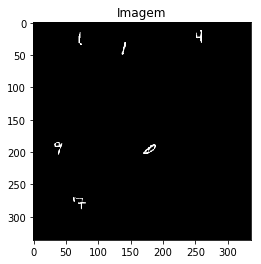

(336, 336)


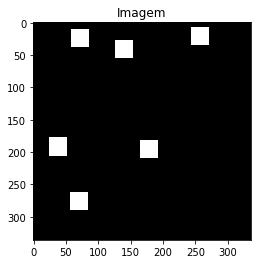

In [83]:
creatorMNIST = CreatorCustomizedMNIST(image_size=(336, 336), digits_count=6)
x_img, y = creatorMNIST.make_sample()
y_img = creatorMNIST.create_image_from_target(y)

ImageUtil.plot_image(x_img)
ImageUtil.plot_image(y_img)

### 2.2 - Criando e salvando o dataset

In [7]:
print("CPU count:", mp.cpu_count())

creatorMNIST.create(3000)
print("Images criadas: ", len(glob.glob("CustomizedMNIST/x/*.png"))) 

CPU count: 32
Dataset already created
Images criadas:  3040


### 2.3 - Classe dataset 

In [8]:
def load_dataset(root='./CustomizedMNIST'):
    x_path = os.path.join(root, "x")
    y_path = os.path.join(root, "y")

    files_x = glob.glob(os.path.join(x_path, "*.png"))
    files_y = glob.glob(os.path.join(y_path, "*.npy"))
    
    files_x.sort()
    files_y.sort()
    
    x, y = [], []
    for file_x, file_y in zip(files_x, files_y):
        x.append(cv.imread(file_x, flags=0))
        y.append(np.load(file_y))
        
    return train_test_split(x, y, test_size=.2)


class ToTensor(object):
    '''
    Convert dataset output to Tensors.
    '''
    def __call__(self, npimage):
        '''
        input numpy image: H x W
        output torch image: C X H X W
        '''
        return torch.unsqueeze(torch.from_numpy(npimage/255), 0).float()
        
        
class CustomizedMNISTDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform
        
        if self.transform is None:
            self.transform = ToTensor()
            
    def __len__(self):
        return len(self.x)
    
    
    def __getitem__(self, i):
        return self.transform(self.x[i]), self.y[i]

### 2.2 - DataLoaders

In [9]:
batch_size = 32

X_train, X_val, y_train, y_val = load_dataset()
dataset_train = CustomizedMNISTDataset(X_train, y_train)
dataset_val = CustomizedMNISTDataset(X_val, y_val)

print("Len(Train): {}\nLen(Val): {}".format(len(dataset_train), len(dataset_val)))

dataloader_train = DataLoader(dataset_train, batch_size=batch_size)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size)

Len(Train): 2432
Len(Val): 608


### 2.3 - Verificando o resultado pelo dataloader

Shapes:  torch.Size([32, 1, 336, 336]) torch.Size([32, 5, 12, 12])
torch.Size([336, 336])


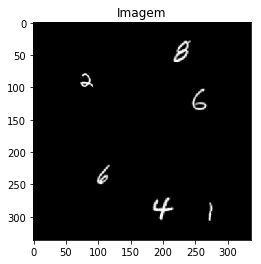

(336, 336)


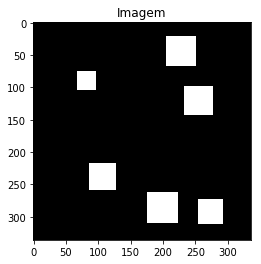

In [10]:
x, y = next(iter(dataloader_train))
print("Shapes: ", x.shape, y.shape)

x_img = x[0]
y_img = creatorMNIST.create_image_from_target(y[0])

ImageUtil.plot_image(x_img.reshape(336, 336))
ImageUtil.plot_image(y_img.reshape(336, 336))

## 3 - Modelo Totalmente Convolucional

In [11]:
class MyModelFullyConv(nn.Module):
    def __init__(self):
        super(MyModelFullyConv, self).__init__()
        
        # Camadas convolucionais
        self.conv_layer = nn.Sequential(OrderedDict([
            
            ('conv1', nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)),   
            ('relu1', nn.ReLU()),
            
            ('max_pool0', nn.MaxPool2d(2)),
            
            ('conv2', nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)),   
            ('relu2', nn.ReLU()),
            
            ('max_pool1', nn.MaxPool2d(2)),
            
            ('conv3', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)),
            ('relu3', nn.ReLU()),
            
            ('max_pool2', nn.MaxPool2d(2)),
            
            ('conv4', nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=2)),
            ('relu4', nn.ReLU()),
            
            ('max_pool3', nn.MaxPool2d(2)),
            
            # ('conv_t1', nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2)),
            # ('relu_t1', nn.ReLU()),
            
            # ('conv5', nn.Conv2d(in_channels=128, out_channels=32, kernel_size=3, padding=1)),
            # ('relu5', nn.ReLU()),
            
            # ('conv_t2', nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2)),
            # ('relu_t2', nn.ReLU()),
            
            # ('conv6', nn.Conv2d(in_channels=64, out_channels=32, kernel_size=5, padding=2)),   
            # ('relu6', nn.ReLU()),
            
            ('conv5', nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=2)),
            ('relu5', nn.ReLU()),
            
            ('max_pool4', nn.MaxPool2d(2)),
            
            
            ('conv7', nn.Conv2d(in_channels=16, out_channels=5, kernel_size=3, padding=1)),
            ('relu6', nn.ReLU())
            
            # ('max_pool3', nn.MaxPool2d(2)),
            
            # ('softmax', nn.Softmax2d())
            
        ]))
        
    def forward(self, x):
        x = self.conv_layer(x)        
        return x

### 3.1 - Observando a saida de cada camada

In [12]:
model_conv = MyModelFullyConv().cuda()
x = torch.zeros(1, 1, 336, 336).cuda()

print('{:10}: {}'.format('input', str(x.size())))

for name, layer in model_conv.conv_layer.named_children():
    x = layer(x)
    print('{:10}: {}'.format(name, str(x.size())))
    

input     : torch.Size([1, 1, 336, 336])
conv1     : torch.Size([1, 16, 336, 336])
relu1     : torch.Size([1, 16, 336, 336])
max_pool0 : torch.Size([1, 16, 168, 168])
conv2     : torch.Size([1, 32, 168, 168])
relu2     : torch.Size([1, 32, 168, 168])
max_pool1 : torch.Size([1, 32, 84, 84])
conv3     : torch.Size([1, 64, 84, 84])
relu3     : torch.Size([1, 64, 84, 84])
max_pool2 : torch.Size([1, 64, 42, 42])
conv4     : torch.Size([1, 32, 44, 44])
relu4     : torch.Size([1, 32, 44, 44])
max_pool3 : torch.Size([1, 32, 22, 22])
conv5     : torch.Size([1, 16, 24, 24])
relu5     : torch.Size([1, 16, 24, 24])
max_pool4 : torch.Size([1, 16, 12, 12])
conv7     : torch.Size([1, 5, 12, 12])


### 3.2 - Fazendo a predição de um batch

In [13]:
model_conv.eval()

x, y = next(iter(dataloader_train))
print("Train shape:", x.shape)

img_pred = model_conv(x.to(device))
print("Pred shape:", img_pred.shape)

Train shape: torch.Size([32, 1, 336, 336])
Pred shape: torch.Size([32, 5, 12, 12])


### 3.3 - Função custumizada de Loss

In [63]:
class MyLoss(nn.modules.loss._Loss):
    def __init__(self, size_average=None, reduce=None, reduction='elementwise_mean', weights=(1, 1, 1)):
        super(MyLoss, self).__init__(size_average, reduce, reduction)
        self.presence_loss = nn.BCEWithLogitsLoss()
        self.box_loss = nn.SmoothL1Loss(reduction='none') 
        self.cls_loss = nn.SmoothL1Loss(reduction='none')
        self.weights = weights
    
    def forward(self,pred, target):
        # (1, tx, ty, size, y)
        target = target.type("torch.cuda.FloatTensor")
        
        box_pred = pred[:, 1:4, :, :]
        box_target = target[:, 1:4, :, :]
        
        presence_pred = pred[:, 0, :, :].unsqueeze(1)
        presence_target = target[:, 0, :, :].unsqueeze(1)
        
        cls_pred = pred[:, 4, :, :].unsqueeze(1)
        cls_target = target[:, 4, :, :].unsqueeze(1)
        
        # Loss de presença
        presence_loss = self.presence_loss(presence_pred, presence_target)
        
        # Loss BB
        box_loss = self.box_loss(box_pred, box_target) * presence_target
        
        # Loss Classe
        # cls_pred = nn.Softmax2d()(cls_pred)
        # print(cls_pred.shape)
        # print(cls_target.shape)
        cls_loss = self.cls_loss(cls_pred, cls_target) * presence_target
        
        # print("Presenca: ", presence_loss)
        # print("BBOX: ", box_loss.sum())
        # print("CLASS: ", cls_loss.mean())
        
        loss = self.weights[1]*presence_loss + self.weights[0]*(box_loss.mean()) +  + self.weights[2]*(cls_loss.mean())
        
        return loss
    

**Testando a função de custo**

In [64]:
model_conv.eval()

x, y = next(iter(dataloader_train))

y_pred = model_conv(x.to(device))

# print(y_pred.shape)
# print(y.shape)

loss = MyLoss()(y_pred, y.cuda())

print(loss)

tensor(1.7907, grad_fn=<ThAddBackward>)


In [65]:
optm = torch.optim.Adam(params=model_conv.parameters())
schd = torch.optim.lr_scheduler.StepLR(optm, step_size=7, gamma=0.1)
cb_chkpt = ptt.ModelCheckpoint('./saved_model', reset=True, verbose=1)

trainer = ptt.DeepNetTrainer(model         = model_conv,
                             criterion     = MyLoss(),
                             optimizer     = optm,
                             lr_scheduler  = schd,
                             callbacks     = [cb_chkpt,
                                              ptt.PrintCallback()],
                             devname       = device)


In [66]:
if True:
    n_epochs = 100
    trainer.fit_loader(n_epochs, dataloader_train, dataloader_val)
else:
    # !wget -nc -q https://www.dropbox.com/s/1xzp51l36spoeta/last_model.model
    trainer.load_state('saved_model')
    trainer.fit_loader(1, dataloader_train, dataloader_val)

Start training for 100 epochs
  1:   4.4s   T: 0.02628 *   V: 0.01447 *  
  2:   4.3s   T: 0.01319 *   V: 0.01217 *  
  3:   4.3s   T: 0.01177 *   V: 0.01117 *  
  4:   4.3s   T: 0.01093 *   V: 0.01055 *  
  5:   4.3s   T: 0.01037 *   V: 0.01003 *  
  6:   4.3s   T: 0.00987 *   V: 0.00961 *  
  7:   4.3s   T: 0.00941 *   V: 0.00916 *  
  8:   4.3s   T: 0.00899 *   V: 0.00901 *  
  9:   4.3s   T: 0.00892 *   V: 0.00896 *  
 10:   4.3s   T: 0.00887 *   V: 0.00891 *  
 11:   4.3s   T: 0.00882 *   V: 0.00886 *  
 12:   4.3s   T: 0.00876 *   V: 0.00881 *  
 13:   4.3s   T: 0.00871 *   V: 0.00876 *  
 14:   4.3s   T: 0.00865 *   V: 0.00870 *  
 15:   4.3s   T: 0.00860 *   V: 0.00869 *  
 16:   4.3s   T: 0.00860 *   V: 0.00868 *  
 17:   4.3s   T: 0.00859 *   V: 0.00868 *  
 18:   4.3s   T: 0.00858 *   V: 0.00867 *  
 19:   4.3s   T: 0.00858 *   V: 0.00866 *  
 20:   4.3s   T: 0.00857 *   V: 0.00866 *  
 21:   4.3s   T: 0.00857 *   V: 0.00865 *  
 22:   4.3s   T: 0.00856 *   V: 0.00865 *  
 2

### 3.4 - Teste do treinamento

tensor([[ -5.4178,  -6.0107,  -6.3687,  -6.2989,  -6.2990,  -8.4101,  -5.7442,
          -5.3221,  -7.8813,  -7.7430,  -4.6285,  -7.3339],
        [ -6.0443,  -7.5022,  -7.9458,  -8.0513,  -7.9491, -11.8289,  -1.9528,
           3.2145,  -2.7319,  -8.3294,  -5.2957, -10.9715],
        [ -9.3676,  -3.5597,  -1.8636,  -4.2858,  -7.0512, -11.1411,  -6.1493,
          -3.6143,  -5.9061,  -5.9798,  -4.0826,  -9.5204],
        [-10.7195,  -0.4507,   0.1579,  -3.9561,  -9.2196, -12.1098,  -8.5899,
          -9.1135, -10.5275,  -7.6625,  -5.8017, -11.2326],
        [ -8.0114,  -3.9510,  -4.4980,  -8.0101,  -8.9674, -14.0416,  -3.1235,
          -1.3587,  -5.8417,  -8.1972,  -5.8017, -11.2326],
        [ -6.8106,  -7.7716,  -8.5483, -11.7122,  -7.6288, -10.7137,  -3.6368,
          -0.1566,  -6.6122,  -8.1561,  -5.8017, -11.2326],
        [ -6.2699,  -7.4261,  -7.3830, -14.5572,  -2.8634,  -1.3388,  -5.8748,
          -8.6294,  -9.2798,  -7.3917,  -5.8017, -11.2326],
        [ -2.0907,  -0.4710

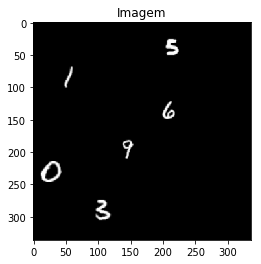

(336, 336)


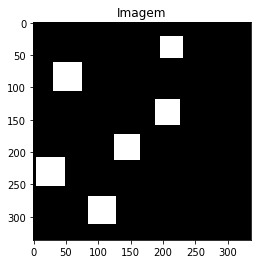

In [74]:
model_conv.eval()

x, y = next(iter(dataloader_val))
pred = model_conv(x.cuda()).cpu()

(k, c, w, h) = x.shape

print(pred[0, 0, :, :])

for i in range(k):
    print("Imagem:")
    print(x[i].shape, x[i].squeeze(0).shape)
    ImageUtil.plot_image(x[i].reshape(336, 336))  
    
    y_img = creatorMNIST.create_image_from_target(y[i])
    ImageUtil.plot_image(y_img)
    # print("Target Pred.:")
    # ImageUtil.plot_target(pred[i])
    break;

## 4 - Aplicando o classificador em Mult digitos

**Gerando amostras**

In [ ]:
m_mnist = CreatorCustomizedMNIST(image_size=(200,200), mnist_batch=10)
img = torch.tensor(m_mnist.make_sample()[0]).float()
plt.grid(False)
plt.imshow(img, cmap="gray")
plt.colorbar()

### 4.2 - Output da predição

In [ ]:
#model_conv.eval()

img = torch.tensor(img).float().reshape(1, 1, 200, 200).cuda()
pred = model_conv(img)

print(pred[0].shape)

max_pred, max_class = pred[0][:-1].max(dim=0)

print("Imagem:")
print(img.shape)
ImageUtil.plot_image(img.reshape(200, 200))
print("Target Pred.:")
ImageUtil.plot_target(pred.reshape(4, 10, 10).cpu().detach())

### 4.3 - Mapa de calor

In [ ]:
hot_map = max_pred.data.cpu().numpy()
plt.imshow(hot_map.reshape(10, 10), plt.cm.hot)
plt.colorbar()
plt.show()

### 4.4 - Utilizando morfologia para encontrar os BB

In [ ]:
import skimage
from skimage.morphology import square

disk = square(28)
disk[20, 20] = 0
clip = np.clip(hot_map, 0.6, 1.0)
dil = skimage.morphology.dilation(clip, disk)
cc = hot_map >= dil
plt.imshow(cc, cmap="gray")
plt.title(str(name))
plt.show()

new_img = img.cpu().numpy().reshape(200, 200)

for row, col in np.transpose(np.nonzero(cc)):
    cv.rectangle(new_img, (col - 14, row - 14), (col + 14, row + 14), 0.8)
    cv.putText(new_img, str(int(max_class[row, col])), (col - 14, row + 14), cv.FONT_HERSHEY_PLAIN, 1, 1)

plt.grid(False)
plt.imshow(new_img, cmap='gray')  
plt.title("Final result " + str(name))
plt.show()